# Simple Simulation of self driving car

The example uses matplotlib.animation to built a simple simulation showing how Skater could be used to enable
inference on a image classification problem(autonomous driving by predicting steering angle). This is an extension of toy example illustrated here https://github.com/datascienceinc/Skater/blob/master/examples/image_interpretability/self_driving_toy_example/toy_self_driving_example.ipynb

The example is a modification of the work done detailed here https://github.com/experiencor/self-driving-toy-car/blob/master/network/Learn%20to%20Drive.ipynb. The model and retraining is pretty much used as described in the reference link. Model Inference is enabled using Skater.

## Experiment Setup

In [11]:
import cv2
import time
import numpy as np
import os, sys, random
from imgaug import augmenters as iaa
import matplotlib.animation as animation
import matplotlib.pyplot as plt
%matplotlib inline

import keras.utils.vis_utils as vutil
import keras.models as models
from keras.optimizers import SGD
from keras.layers import Input
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape
from keras.layers.convolutional import MaxPooling2D, Conv2D
from keras.utils import np_utils
from keras.layers import GlobalAveragePooling2D, Input
from keras.models import Model
from keras.layers import Input, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
import keras.losses as los

import tensorflow as tf

# Skater related import
from skater.util.image_ops import load_image, show_image, normalize, standard_scaler
from skater.util.dataops import show_in_notebook

STEER_MIDPT = 1500.
STEER_UPPER = 2000.
STEER_LOWER = 1000.

2018-06-11 20:28:14,179 - skater.util.dataops - INFO - File Name: ./rc_car.jpg


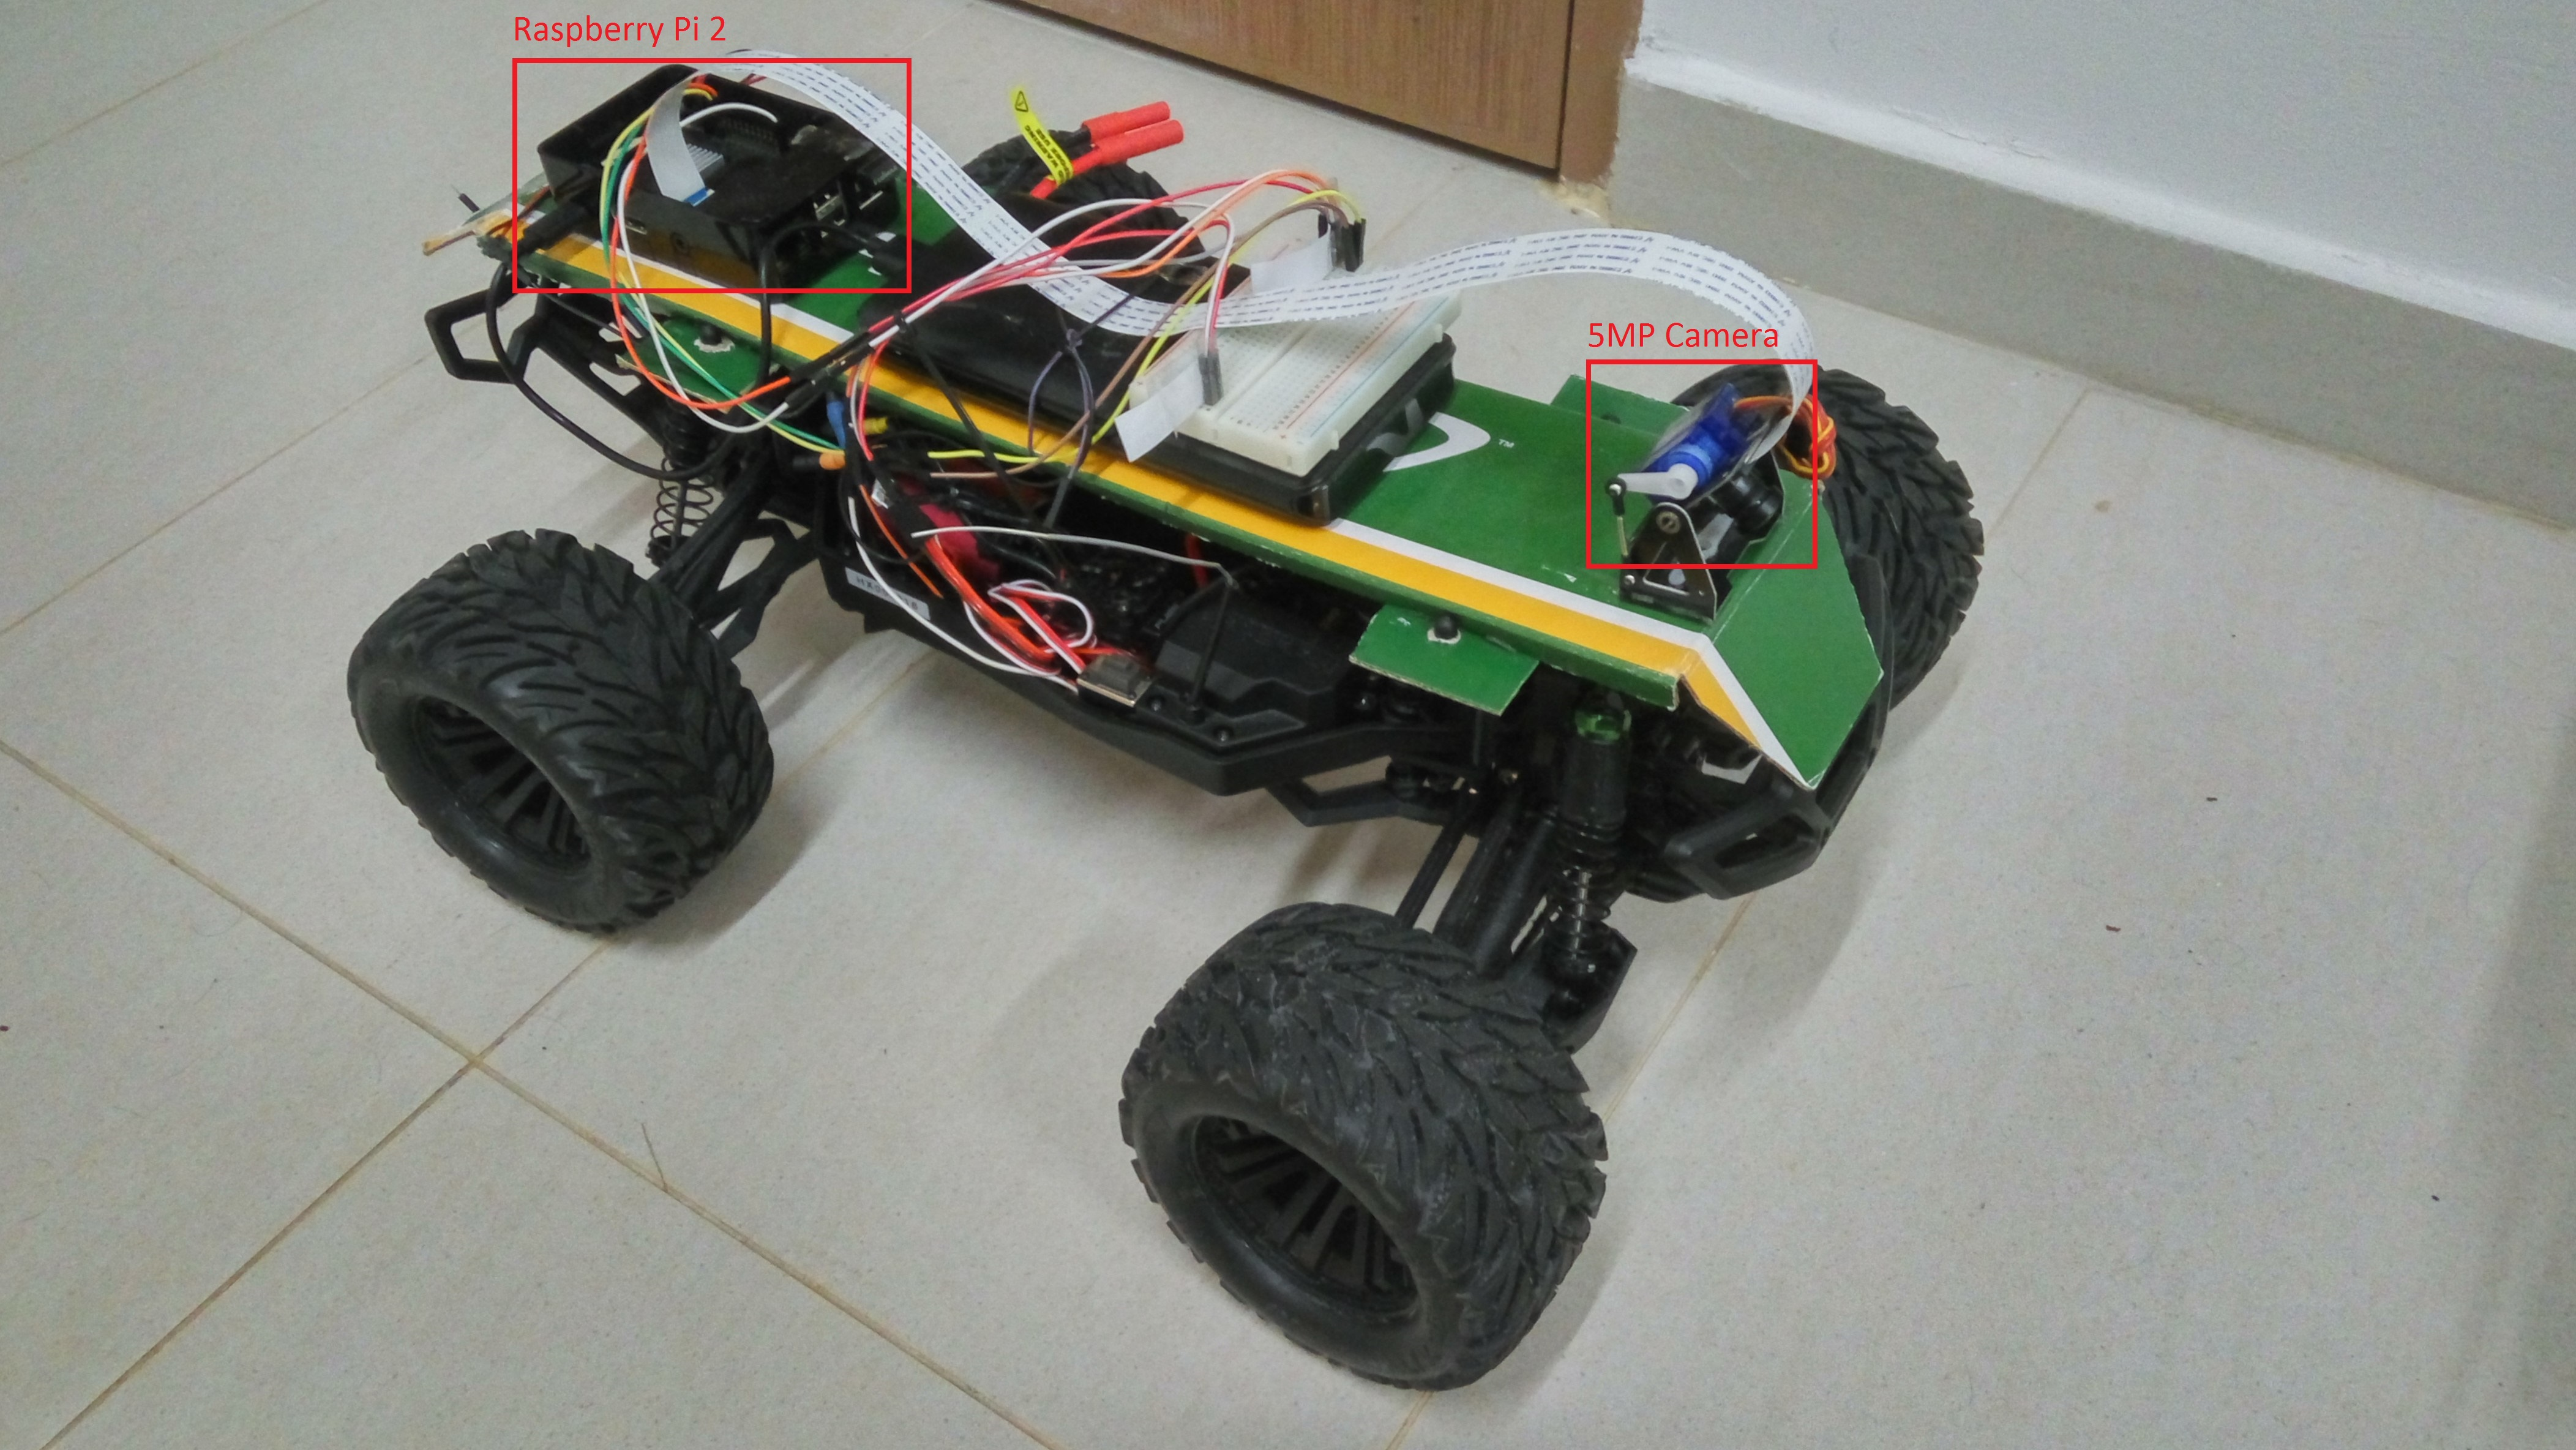

In [12]:
# Image borrowed from the original example,
# https://github.com/experiencor/self-driving-toy-car/blob/master/network/Learn%20to%20Drive.ipynb
show_in_notebook('./rc_car.jpg')

# Data Preprocessing

In [3]:
sometime = lambda aug: iaa.Sometimes(0.3, aug)
sequence = iaa.Sequential([ sometime(iaa.GaussianBlur((0, 1.5))), # blur images with a sigma between 0 and 3.0
                            sometime(iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5))), # sharpen images
                            sometime(iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 3.), per_channel=0.5)), # add gaussian noise to images
                            sometime(iaa.Dropout((0.0, 0.1))), # randomly remove up to 10% of the pixels
                            sometime(iaa.CoarseDropout((0.10, 0.30), size_percent=(0.02, 0.05), per_channel=0.2)),
                            sometime(iaa.Add((-10, 10), per_channel=0.5)), # change brightness of images (by -10 to 10 of original value)
                          ],
                          random_order=True # do all of the above in random order
                         )

In [15]:
def equalize(image):
    from skimage import exposure
    img_eq = exposure.equalize_hist(image)
    return img_eq


def augment(image, steer):
    image = sequence.augment_image(image)
    
    if np.random.random() > 0.5:
        shift = np.random.randint(-2,2)
        
        if shift > 0:
            image[-shift:,:,:] = 0
            image[:-shift,:,:] = image[shift:,:,:]
        elif shift < 0:
            image[:-shift,:,:] = 0
            image[-shift:,:,:] = image[:shift,:,:]
    
    if np.random.random() > 0.5:
        image = cv2.flip(image, 1)
        steer = -steer          
    return image, steer

In [16]:
class BatchGenerator:
    def __init__(self, paths, batch_size, shuffle=True, terminate=False, jitter=True, norm=True):
        self.images = []
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.terminate = terminate
        self.jitter = jitter
        self.norm = norm

        for path in paths:
            image_path = path + '/image/'
            label_path = path + '/steer/'
            self.images += sorted([image_path + path for path in os.listdir(image_path)])
        
        if shuffle: np.random.shuffle(self.images)

    def get_gen(self):
        num_img = len(self.images)
        l_bound = 0
        r_bound = self.batch_size if self.batch_size < num_img else num_img    

        while True:
            if l_bound == r_bound:
                if self.terminate:
                    break
                else:
                    l_bound = 0
                    r_bound = self.batch_size if self.batch_size < num_img else num_img
                    if self.shuffle: np.random.shuffle(self.images)

            x_batch = np.zeros((r_bound - l_bound, FRAME_H, FRAME_W, 3))
            y_batch = np.zeros((r_bound - l_bound, 1))

            for index, image_file in enumerate(self.images[l_bound:r_bound]):
                # construct each input
                image = load_image(image_file, FRAME_H, FRAME_W, crop_from_center=False, rgb2bgr=True, 
                                   preserve_range=True).astype('uint8').copy()

                # construct each output
                steer = open(image_file.replace('image', 'steer').replace('png', 'txt')).read()
                steer = np.clip(float(steer), STEER_LOWER, STEER_UPPER)
                steer = (float(steer) - STEER_MIDPT) / (STEER_UPPER - STEER_MIDPT)

                if self.jitter: image, steer = augment(image, steer)
                #if self.norm: image = normalize(image)
                if self.norm: image = standard_scaler(image)

                x_batch[index] = image
                y_batch[index] = steer
                
            yield x_batch, y_batch

            l_bound = r_bound
            r_bound = r_bound + self.batch_size
            if r_bound > num_img: r_bound = num_img
                
    def get_size(self):
        return len(self.images)

# Construct the network

In [17]:
# Neural Architecture used earlier to build the CNN model
FRAME_H =  80
FRAME_W = 160

def model_definition():
    image_input = Input(shape=(FRAME_H, FRAME_W, 3))

    x = Conv2D(filters=16, kernel_size=(3, 5), activation='relu', padding='valid')(image_input)
    x = Conv2D(filters=16, kernel_size=(3, 5), activation='relu', padding='valid')(x)
    x = MaxPooling2D((4, 2))(x)

    x = Conv2D(filters=32, kernel_size=(3, 5), activation='relu', padding='valid')(x)
    x = Conv2D(filters=32, kernel_size=(3, 5), activation='relu', padding='valid')(x)
    x = MaxPooling2D((4, 2))(x)

    x = Conv2D(filters=4,  kernel_size=(1, 1), activation='linear', padding='same')(x)

    x = Flatten()(x)

    x = Dense(1, kernel_regularizer='l1')(x)
    x = Activation('tanh')(x)
    return Model(inputs=[image_input], outputs=[x])

In [18]:
model = model_definition()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 80, 160, 3)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 78, 156, 16)       736       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 76, 152, 16)       3856      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 19, 76, 16)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 17, 72, 32)        7712      
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 15, 68, 32)        15392     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 3, 34, 32)         0         
__________

# Train the model

In [19]:
early_stop  = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=2, mode='min', verbose=1)
checkpoint  = ModelCheckpoint('weights_toy_example.hdf5', monitor='val_loss', verbose=1, save_best_only=True, 
                              mode='min', period=1)

batch_num = 32
session_t = ['drive_trial_0', 'drive_trial_2']
session_v = ['drive_trial_1', 'drive_trial_3']

gen_train = BatchGenerator(session_t, batch_num)
gen_valid = BatchGenerator(session_v, batch_num, jitter = False)

num_train = gen_train.get_size()/batch_num
num_valid = gen_valid.get_size()/batch_num

In [20]:
model.compile(loss=los.mean_squared_error, optimizer='adam')

model.fit_generator(generator = gen_train.get_gen(),
                    steps_per_epoch = num_train, 
                    epochs  = 3, 
                    verbose = 1,
                    validation_data = gen_valid.get_gen(), 
                    validation_steps = num_valid, 
                    callbacks = [early_stop, checkpoint], 
                    max_q_size = 3)

Epoch 1/3
275/274 [==============================] - 189s - loss: 0.2270 - val_loss: 0.0986
Epoch 2/3
275/274 [==============================] - 187s - loss: 0.0850 - val_loss: 0.0576
Epoch 3/3
275/274 [==============================] - 188s - loss: 0.0628 - val_loss: 0.0378


# Predict and infer steering angle with Skater

In [21]:
# Skater related imports
from skater.core.local_interpretation.dnni.deep_interpreter import DeepInterpreter
from skater.core.visualizer.image_relevance_visualizer import visualize

In [22]:
generator = BatchGenerator(['demo'], 1, shuffle=False, terminate=True, jitter=False, norm=False).get_gen()

(1, 80, 160, 3)


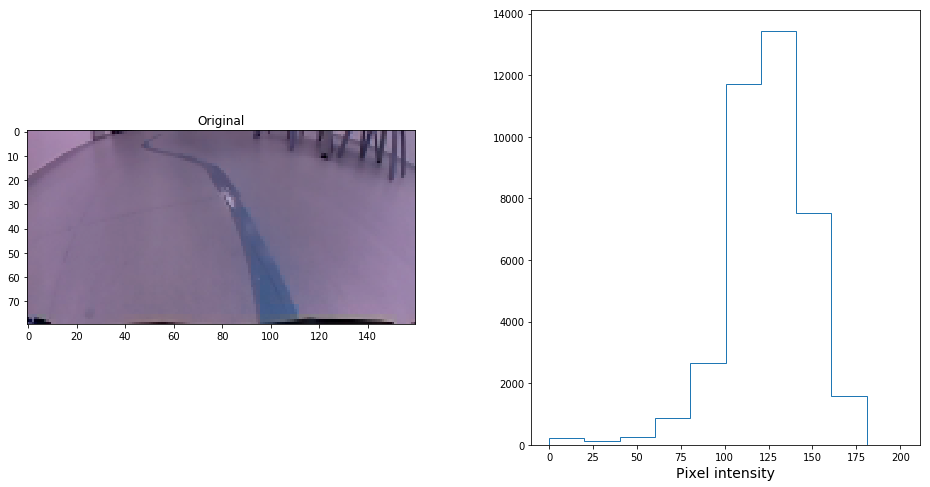

In [23]:
example = next(generator)
print(example[0].shape)
show_image(example[0][0].astype('uint8'))
input_img = example[0][0].astype('uint8').reshape(1, 80, 160, 3)

In [24]:
def infer_relevance(input_x):
    K.set_learning_phase(0)
    with DeepInterpreter(session=K.get_session()) as di:
        loaded_model = model
        # Update the model instance with the pre-trained weights
        loaded_model.load_weights('weights_toy_example.hdf5')
        input_tensor = loaded_model.layers[0].input
        output_tensor = loaded_model.layers[-2].output
        steer_prediction = loaded_model.predict(input_x)
        print("Steering prediction {}".format(steer_prediction))
        optional_args = {"window_size": 1, "step": 1}
        relevance = {
            #'integrated gradient': di.explain('ig', output_tensor, input_tensor, input_x, use_case='image')
            'e-LRP': di.explain('elrp', output_tensor, input_tensor, input_x, use_case='image')
        }
    return (relevance, steer_prediction)

In [25]:
result = infer_relevance(input_img)

2018-06-11 20:41:30,723 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:41:30,724 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


<IPython.core.display.Javascript object>


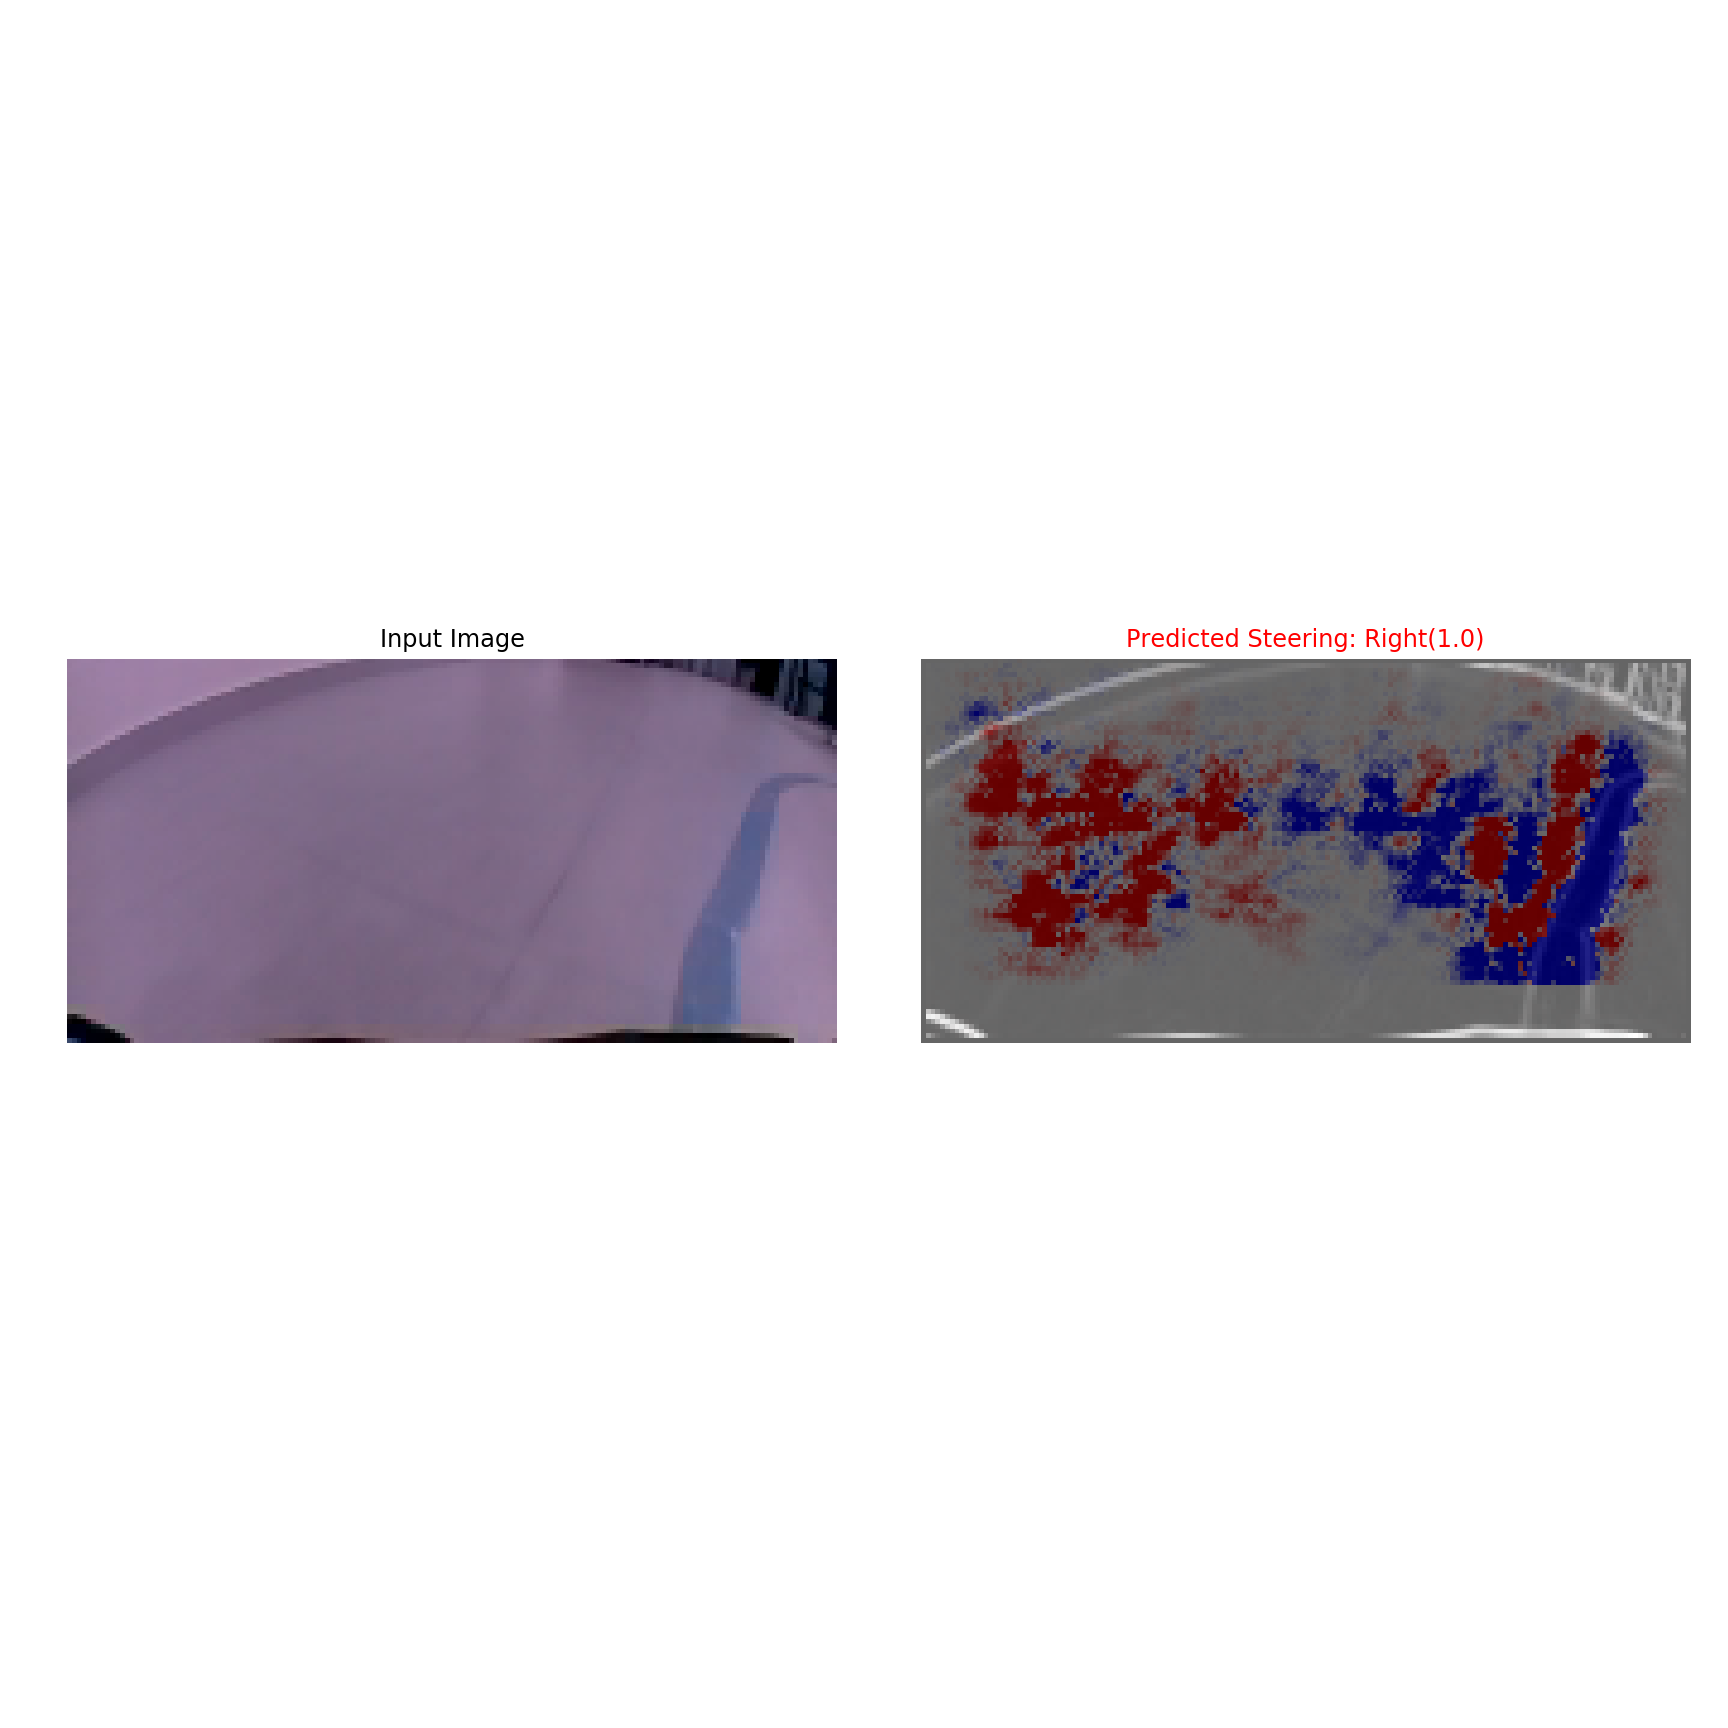

MovieWriter imagemagick unavailable.
2018-06-11 20:43:35,725 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:43:35,726 - BaseGradientMethod - INFO - Executing operations ...
2018-06-11 20:43:35,861 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:43:35,862 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]
Steering prediction [[1.]]


2018-06-11 20:43:36,034 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:43:36,035 - BaseGradientMethod - INFO - Executing operations ...
2018-06-11 20:43:36,219 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:43:36,220 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]
Steering prediction [[1.]]


2018-06-11 20:43:36,417 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:43:36,418 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:43:36,637 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:43:36,638 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:43:36,863 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:43:36,864 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:43:37,098 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:43:37,099 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:43:37,347 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:43:37,348 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:43:37,606 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:43:37,607 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:43:37,875 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:43:37,876 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:43:38,157 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:43:38,157 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:43:38,451 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:43:38,452 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:43:38,761 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:43:38,762 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:43:39,081 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:43:39,082 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:43:39,423 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:43:39,424 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:43:39,775 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:43:39,776 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:43:40,141 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:43:40,142 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:43:40,519 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:43:40,520 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:43:40,905 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:43:40,906 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:43:41,304 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:43:41,305 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:43:41,717 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:43:41,718 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:43:42,146 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:43:42,147 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:43:42,584 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:43:42,585 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:43:43,035 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:43:43,036 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:43:43,506 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:43:43,507 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:43:43,987 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:43:43,988 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:43:44,486 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:43:44,487 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:43:44,993 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:43:44,994 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:43:45,515 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:43:45,516 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:43:46,053 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:43:46,054 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:43:46,591 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:43:46,592 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:43:47,263 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:43:47,264 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:43:47,831 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:43:47,832 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:43:48,412 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:43:48,413 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:43:49,003 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:43:49,004 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:43:49,609 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:43:49,610 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:43:50,227 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:43:50,227 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:43:50,861 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:43:50,862 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:43:51,501 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:43:51,502 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:43:52,163 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:43:52,164 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:43:52,843 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:43:52,844 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:43:53,533 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:43:53,534 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:43:54,237 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:43:54,238 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:43:54,959 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:43:54,960 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:43:55,678 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:43:55,679 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:43:56,403 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:43:56,404 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:43:57,157 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:43:57,158 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:43:57,919 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:43:57,920 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:43:58,686 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:43:58,687 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:43:59,466 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:43:59,468 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:44:00,261 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:44:00,262 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:44:01,081 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:44:01,082 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:44:01,900 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:44:01,901 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[0.9999608]]


2018-06-11 20:44:02,742 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:44:02,744 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[-0.9830129]]


2018-06-11 20:44:03,590 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:44:03,591 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[-0.9999999]]


2018-06-11 20:44:04,451 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:44:04,453 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[0.9915811]]


2018-06-11 20:44:05,360 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:44:05,362 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[0.9922775]]


2018-06-11 20:44:06,250 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:44:06,251 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[0.9999929]]


2018-06-11 20:44:07,154 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:44:07,155 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[0.99999267]]


2018-06-11 20:44:08,078 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:44:08,079 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[0.9987236]]


2018-06-11 20:44:09,022 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:44:09,023 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[-0.965821]]


2018-06-11 20:44:09,972 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:44:09,973 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[-0.99894583]]


2018-06-11 20:44:10,925 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:44:10,926 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[0.9982684]]


2018-06-11 20:44:11,905 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:44:11,906 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[0.9999662]]


2018-06-11 20:44:12,892 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:44:12,893 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:44:13,897 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:44:13,898 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:44:14,908 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:44:14,909 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:44:15,923 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:44:15,924 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:44:16,968 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:44:16,969 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:44:18,028 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:44:18,029 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:44:19,088 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:44:19,089 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:44:20,162 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:44:20,163 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:44:21,243 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:44:21,244 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:44:22,356 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:44:22,357 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:44:23,481 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:44:23,482 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:44:24,605 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:44:24,606 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:44:25,735 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:44:25,736 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:44:26,881 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:44:26,882 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:44:28,032 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:44:28,033 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:44:29,214 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:44:29,215 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:44:30,569 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:44:30,570 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:44:31,766 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:44:31,767 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:44:32,993 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:44:32,994 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:44:34,242 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:44:34,243 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:44:35,516 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:44:35,517 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:44:36,790 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:44:36,791 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:44:38,056 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:44:38,057 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:44:39,326 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:44:39,327 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:44:40,615 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:44:40,616 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:44:41,942 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:44:41,943 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:44:43,275 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:44:43,276 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:44:44,629 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:44:44,630 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:44:46,003 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:44:46,004 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:44:47,359 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:44:47,360 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:44:48,730 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:44:48,731 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:44:50,108 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:44:50,109 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:44:51,500 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:44:51,501 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:44:52,901 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:44:52,902 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:44:54,311 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:44:54,312 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:44:55,745 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:44:55,745 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:44:57,210 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:44:57,211 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:44:58,668 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:44:58,669 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:45:00,132 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:45:00,133 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:45:01,639 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:45:01,640 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:45:03,167 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:45:03,168 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:45:04,689 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:45:04,690 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:45:06,212 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:45:06,213 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:45:07,772 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:45:07,772 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:45:09,319 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:45:09,320 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:45:10,882 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:45:10,884 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:45:12,464 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:45:12,465 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:45:14,050 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:45:14,051 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:45:15,669 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:45:15,670 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:45:17,345 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:45:17,346 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:45:18,972 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:45:18,973 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:45:20,613 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:45:20,614 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:45:22,295 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:45:22,296 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:45:23,965 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:45:23,966 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[-0.9991255]]


2018-06-11 20:45:25,642 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:45:25,643 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[-1.]]


2018-06-11 20:45:27,333 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:45:27,334 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[-1.]]


2018-06-11 20:45:29,074 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:45:29,075 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[-1.]]


2018-06-11 20:45:30,819 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:45:30,820 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[-1.]]


2018-06-11 20:45:32,573 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:45:32,574 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[-1.]]


2018-06-11 20:45:34,329 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:45:34,330 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[-1.]]


2018-06-11 20:45:36,115 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:45:36,116 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[-1.]]


2018-06-11 20:45:37,913 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:45:37,914 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[-1.]]


2018-06-11 20:45:39,704 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:45:39,705 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[-1.]]


2018-06-11 20:45:41,512 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:45:41,513 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[-1.]]


2018-06-11 20:45:43,319 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:45:43,320 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[-1.]]


2018-06-11 20:45:45,162 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:45:45,163 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[-1.]]


2018-06-11 20:45:47,000 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:45:47,001 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[-1.]]


2018-06-11 20:45:48,892 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:45:48,893 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[-0.99991035]]


2018-06-11 20:45:50,767 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:45:50,768 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[0.9999998]]


2018-06-11 20:45:52,649 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:45:52,650 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:45:54,561 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:45:54,562 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:45:56,470 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:45:56,471 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:45:58,397 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:45:58,398 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:46:00,331 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:46:00,332 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:46:02,279 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:46:02,280 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:46:04,288 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:46:04,289 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:46:06,464 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:46:06,466 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:46:08,477 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:46:08,478 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:46:10,469 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:46:10,470 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:46:12,479 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:46:12,480 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:46:14,506 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:46:14,508 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:46:16,565 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:46:16,566 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:46:18,626 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:46:18,627 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:46:20,682 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:46:20,683 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:46:22,758 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:46:22,759 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:46:24,856 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:46:24,857 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:46:26,965 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:46:26,966 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:46:29,089 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:46:29,090 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:46:31,252 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:46:31,253 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:46:33,438 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:46:33,439 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:46:35,652 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:46:35,653 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:46:37,867 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:46:37,868 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:46:40,074 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:46:40,075 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:46:42,312 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:46:42,314 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:46:44,521 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:46:44,522 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:46:46,787 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:46:46,788 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:46:49,037 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:46:49,038 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:46:51,313 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:46:51,314 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:46:53,567 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:46:53,569 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:46:55,870 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:46:55,871 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:46:58,192 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:46:58,193 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:47:00,500 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:47:00,501 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:47:02,871 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:47:02,872 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:47:05,247 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:47:05,248 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:47:07,633 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:47:07,635 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:47:10,035 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:47:10,036 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:47:12,470 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:47:12,471 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:47:14,881 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:47:14,882 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:47:17,277 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:47:17,278 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:47:19,672 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:47:19,673 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:47:22,083 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:47:22,084 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:47:24,507 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:47:24,508 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:47:26,974 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:47:26,975 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:47:29,461 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:47:29,462 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[0.99997276]]


2018-06-11 20:47:31,962 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:47:31,963 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[0.99064034]]


2018-06-11 20:47:34,463 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:47:34,464 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[-0.73517275]]


2018-06-11 20:47:36,974 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:47:36,975 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[0.99999976]]


2018-06-11 20:47:39,543 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:47:39,544 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:47:42,074 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:47:42,075 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:47:44,609 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:47:44,610 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:47:47,167 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:47:47,169 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:47:49,732 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:47:49,733 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:47:52,319 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:47:52,321 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:47:54,911 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:47:54,912 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:47:57,518 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:47:57,519 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:48:00,138 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:48:00,139 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:48:02,776 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:48:02,777 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:48:05,451 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:48:05,452 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:48:08,187 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:48:08,188 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:48:10,912 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:48:10,913 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:48:13,679 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:48:13,680 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:48:16,407 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:48:16,409 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:48:19,126 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:48:19,127 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:48:21,846 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:48:21,848 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:48:24,595 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:48:24,596 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:48:27,341 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:48:27,342 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:48:30,131 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:48:30,132 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:48:32,947 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:48:32,948 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:48:35,775 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:48:35,776 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:48:38,620 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:48:38,621 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:48:41,497 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:48:41,498 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:48:44,371 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:48:44,372 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:48:47,254 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:48:47,255 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:48:50,164 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:48:50,165 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:48:53,082 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:48:53,083 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:48:56,010 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:48:56,011 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:48:58,913 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:48:58,914 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:49:01,826 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:49:01,827 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:49:04,964 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:49:04,965 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:49:07,954 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:49:07,955 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:49:10,922 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:49:10,923 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:49:13,933 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:49:13,934 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:49:16,958 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:49:16,959 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:49:19,948 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:49:19,949 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:49:22,955 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:49:22,956 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:49:25,980 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:49:25,982 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:49:29,010 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:49:29,011 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:49:32,065 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:49:32,066 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:49:35,107 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:49:35,108 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:49:38,164 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:49:38,165 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:49:41,250 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:49:41,251 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:49:44,397 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:49:44,398 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:49:47,510 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:49:47,511 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:49:50,682 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:49:50,683 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:49:53,870 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:49:53,871 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:49:57,009 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:49:57,010 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:50:00,222 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:50:00,223 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:50:03,467 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:50:03,468 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:50:06,655 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:50:06,656 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:50:09,875 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:50:09,876 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:50:13,090 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:50:13,091 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:50:16,354 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:50:16,355 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:50:19,635 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:50:19,636 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:50:22,887 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:50:22,888 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:50:26,190 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:50:26,191 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:50:29,526 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:50:29,527 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:50:32,823 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:50:32,824 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:50:36,184 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:50:36,185 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:50:39,495 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:50:39,496 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:50:42,826 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:50:42,827 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:50:46,175 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:50:46,176 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:50:49,591 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:50:49,592 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[0.99999976]]


2018-06-11 20:50:52,985 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:50:52,986 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[0.96003866]]


2018-06-11 20:50:56,382 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:50:56,383 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[-0.99959826]]


2018-06-11 20:50:59,777 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:50:59,778 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[-1.]]


2018-06-11 20:51:03,197 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:51:03,198 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[-1.]]


2018-06-11 20:51:06,629 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:51:06,630 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[-1.]]


2018-06-11 20:51:10,126 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:51:10,127 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[-1.]]


2018-06-11 20:51:13,623 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:51:13,624 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[-1.]]


2018-06-11 20:51:17,085 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:51:17,086 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[-1.]]


2018-06-11 20:51:20,562 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:51:20,563 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[-1.]]


2018-06-11 20:51:24,079 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:51:24,080 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[-1.]]


2018-06-11 20:51:27,639 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:51:27,640 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[-1.]]


2018-06-11 20:51:31,227 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:51:31,228 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[-1.]]


2018-06-11 20:51:34,767 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:51:34,768 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[-1.]]


2018-06-11 20:51:38,321 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:51:38,322 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[-1.]]


2018-06-11 20:51:41,891 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:51:41,892 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[0.9053076]]


2018-06-11 20:51:45,474 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:51:45,474 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:51:49,072 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:51:49,073 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:51:52,691 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:51:52,692 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:51:56,318 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:51:56,319 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:51:59,952 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:51:59,953 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:52:03,608 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:52:03,609 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:52:07,267 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:52:07,268 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:52:10,985 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:52:10,986 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:52:14,746 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:52:14,747 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:52:18,498 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:52:18,499 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:52:22,227 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:52:22,228 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:52:25,982 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:52:25,983 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:52:29,722 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:52:29,723 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:52:33,549 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:52:33,550 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:52:37,328 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:52:37,329 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:52:41,101 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:52:41,102 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:52:44,894 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:52:44,896 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:52:48,743 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:52:48,744 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:52:52,629 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:52:52,630 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:52:56,460 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:52:56,461 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:53:00,363 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:53:00,364 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:53:04,284 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:53:04,285 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:53:08,183 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:53:08,184 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:53:12,090 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:53:12,091 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:53:15,973 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:53:15,975 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:53:19,961 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:53:19,962 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:53:23,958 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:53:23,959 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:53:27,972 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:53:27,973 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:53:31,979 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:53:31,980 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:53:36,001 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:53:36,003 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:53:39,980 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:53:39,981 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:53:44,042 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:53:44,043 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:53:48,047 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:53:48,048 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:53:52,066 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:53:52,067 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:53:56,157 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:53:56,158 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:54:00,203 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:54:00,204 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:54:04,257 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:54:04,258 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:54:08,411 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:54:08,412 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:54:12,580 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:54:12,581 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:54:16,760 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:54:16,761 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:54:20,925 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:54:20,926 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:54:25,364 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:54:25,365 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:54:29,567 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:54:29,568 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:54:33,817 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:54:33,818 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:54:38,070 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:54:38,071 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:54:42,337 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:54:42,338 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:54:46,627 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:54:46,628 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:54:50,862 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:54:50,863 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:54:55,164 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:54:55,165 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:54:59,452 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:54:59,453 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:55:03,784 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:55:03,785 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:55:08,128 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:55:08,129 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:55:12,504 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:55:12,505 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:55:16,819 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:55:16,820 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:55:21,204 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:55:21,205 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:55:25,621 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:55:25,622 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:55:29,977 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:55:29,978 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:55:34,387 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:55:34,388 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:55:38,754 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:55:38,755 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:55:43,148 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:55:43,150 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:55:47,588 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:55:47,589 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:55:52,072 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:55:52,073 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:55:56,527 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:55:56,528 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:56:01,017 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:56:01,019 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:56:05,564 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:56:05,565 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:56:10,146 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:56:10,147 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:56:14,727 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:56:14,728 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:56:19,290 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:56:19,291 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:56:23,864 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:56:23,865 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:56:28,461 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:56:28,462 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[0.9996953]]


2018-06-11 20:56:33,097 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:56:33,098 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[0.8805229]]


2018-06-11 20:56:37,720 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:56:37,721 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[-0.85143507]]


2018-06-11 20:56:42,362 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:56:42,363 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[0.9999999]]


2018-06-11 20:56:47,010 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:56:47,011 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:56:51,609 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:56:51,610 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:56:56,288 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:56:56,289 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:57:00,975 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:57:00,976 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:57:05,606 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:57:05,607 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:57:10,321 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:57:10,322 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:57:15,063 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:57:15,064 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:57:19,801 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:57:19,802 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:57:24,558 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:57:24,559 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:57:29,252 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:57:29,253 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:57:34,064 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:57:34,065 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:57:38,796 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:57:38,797 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:57:43,600 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:57:43,601 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:57:48,348 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:57:48,349 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:57:53,159 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:57:53,159 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:57:57,986 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:57:57,987 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:58:02,840 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:58:02,841 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:58:07,707 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:58:07,708 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:58:12,525 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:58:12,526 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:58:17,406 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:58:17,407 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:58:22,260 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:58:22,261 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:58:27,124 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:58:27,125 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:58:32,037 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:58:32,038 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:58:36,932 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:58:36,933 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:58:41,898 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:58:41,899 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:58:46,808 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:58:46,809 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:58:51,816 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:58:51,817 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:58:56,754 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:58:56,755 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:59:01,702 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:59:01,703 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:59:06,680 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:59:06,681 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:59:11,713 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:59:11,714 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:59:16,711 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:59:16,712 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:59:21,784 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:59:21,785 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:59:26,873 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:59:26,874 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:59:31,909 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:59:31,910 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:59:36,953 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:59:36,954 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:59:42,015 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:59:42,016 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:59:47,173 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:59:47,174 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:59:52,349 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:59:52,350 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 20:59:57,521 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 20:59:57,522 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:00:02,725 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:00:02,726 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:00:07,943 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:00:07,944 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:00:13,170 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:00:13,172 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:00:18,417 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:00:18,418 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:00:23,689 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:00:23,690 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:00:29,000 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:00:29,001 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:00:34,210 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:00:34,211 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:00:39,423 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:00:39,423 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:00:44,743 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:00:44,744 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:00:50,061 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:00:50,062 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:00:55,309 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:00:55,310 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:01:00,588 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:01:00,589 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:01:05,952 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:01:05,953 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:01:11,339 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:01:11,339 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:01:16,719 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:01:16,720 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:01:22,158 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:01:22,159 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:01:27,577 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:01:27,579 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:01:33,002 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:01:33,003 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:01:38,426 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:01:38,427 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:01:43,878 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:01:43,879 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:01:49,285 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:01:49,286 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:01:54,687 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:01:54,688 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:02:00,099 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:02:00,100 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:02:05,646 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:02:05,647 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:02:11,182 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:02:11,183 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:02:16,732 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:02:16,733 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:02:22,309 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:02:22,310 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:02:27,870 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:02:27,871 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:02:33,377 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:02:33,378 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:02:38,888 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:02:38,889 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:02:44,410 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:02:44,411 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:02:49,960 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:02:49,961 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:02:55,506 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:02:55,507 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:03:01,060 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:03:01,061 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:03:06,762 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:03:06,763 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:03:12,436 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:03:12,437 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:03:18,112 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:03:18,113 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:03:23,821 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:03:23,822 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:03:29,531 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:03:29,532 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:03:35,263 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:03:35,264 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:03:41,319 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:03:41,320 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:03:47,111 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:03:47,112 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:03:52,840 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:03:52,841 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:03:58,637 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:03:58,638 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:04:04,354 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:04:04,355 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:04:10,164 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:04:10,165 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:04:16,007 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:04:16,008 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:04:21,849 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:04:21,850 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:04:27,717 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:04:27,718 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:04:33,594 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:04:33,595 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[0.9999995]]


2018-06-11 21:04:39,398 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:04:39,399 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[0.9081214]]


2018-06-11 21:04:45,223 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:04:45,224 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[-1.]]


2018-06-11 21:04:51,055 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:04:51,056 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[-1.]]


2018-06-11 21:04:56,922 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:04:56,923 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[-1.]]


2018-06-11 21:05:02,866 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:05:02,867 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[-1.]]


2018-06-11 21:05:08,862 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:05:08,863 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[-1.]]


2018-06-11 21:05:14,780 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:05:14,781 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[-1.]]


2018-06-11 21:05:20,785 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:05:20,786 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[-1.]]


2018-06-11 21:05:26,824 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:05:26,825 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[-1.]]


2018-06-11 21:05:32,763 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:05:32,764 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[-1.]]


2018-06-11 21:05:38,823 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:05:38,824 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[-1.]]


2018-06-11 21:05:44,909 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:05:44,910 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[-1.]]


2018-06-11 21:05:50,998 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:05:50,999 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[-1.]]


2018-06-11 21:05:56,973 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:05:56,974 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[-1.]]


2018-06-11 21:06:03,089 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:06:03,090 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[-1.]]


2018-06-11 21:06:09,123 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:06:09,124 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[-1.]]


2018-06-11 21:06:15,160 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:06:15,161 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:06:21,198 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:06:21,199 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:06:27,349 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:06:27,350 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:06:33,456 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:06:33,457 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:06:39,658 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:06:39,659 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:06:45,789 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:06:45,790 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:06:51,919 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:06:51,920 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:06:58,047 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:06:58,048 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:07:04,291 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:07:04,292 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:07:10,554 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:07:10,555 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:07:16,806 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:07:16,807 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:07:23,001 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:07:23,002 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:07:29,312 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:07:29,313 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:07:35,580 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:07:35,581 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:07:41,841 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:07:41,842 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:07:48,184 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:07:48,185 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:07:54,515 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:07:54,516 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:08:00,869 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:08:00,870 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:08:07,250 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:08:07,251 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:08:13,581 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:08:13,582 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:08:19,904 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:08:19,905 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:08:26,201 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:08:26,202 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:08:32,557 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:08:32,558 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:08:38,982 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:08:38,983 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:08:45,408 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:08:45,409 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:08:51,895 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:08:51,897 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:08:58,265 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:08:58,267 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:09:04,680 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:09:04,681 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:09:11,167 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:09:11,168 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:09:17,719 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:09:17,720 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:09:24,171 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:09:24,172 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:09:30,673 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:09:30,674 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:09:37,133 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:09:37,134 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:09:43,736 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:09:43,737 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:09:50,258 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:09:50,259 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:09:56,826 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:09:56,827 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:10:03,461 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:10:03,462 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:10:10,130 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:10:10,131 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:10:16,785 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:10:16,786 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:10:23,474 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:10:23,475 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:10:30,135 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:10:30,136 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:10:36,749 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:10:36,750 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:10:43,462 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:10:43,463 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:10:50,181 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:10:50,182 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:10:56,921 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:10:56,922 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:11:03,702 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:11:03,703 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:11:10,493 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:11:10,494 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:11:17,278 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:11:17,279 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:11:23,980 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:11:23,981 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:11:31,090 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:11:31,091 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:11:37,827 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:11:37,828 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:11:44,695 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:11:44,696 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[0.99999976]]


2018-06-11 21:11:51,546 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:11:51,547 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[-0.9574515]]


2018-06-11 21:11:58,395 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:11:58,396 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[-0.9974359]]


2018-06-11 21:12:05,279 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:12:05,280 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:12:12,166 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:12:12,167 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:12:19,057 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:12:19,058 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:12:25,894 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:12:25,895 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:12:32,745 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:12:32,746 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:12:39,573 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:12:39,574 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:12:46,423 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:12:46,424 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:12:53,407 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:12:53,408 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:13:00,288 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:13:00,289 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:13:07,290 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:13:07,291 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:13:14,310 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:13:14,311 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:13:21,251 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:13:21,252 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:13:28,264 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:13:28,265 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:13:35,237 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:13:35,238 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:13:42,303 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:13:42,304 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:13:49,392 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:13:49,393 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:13:56,378 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:13:56,379 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:14:03,496 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:14:03,497 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:14:10,600 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:14:10,601 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:14:17,747 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:14:17,748 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:14:24,875 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:14:24,876 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:14:32,035 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:14:32,036 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:14:39,209 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:14:39,210 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:14:46,380 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:14:46,381 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:14:53,628 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:14:53,629 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:15:00,853 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:15:00,854 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:15:08,024 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:15:08,025 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:15:15,325 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:15:15,326 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:15:22,495 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:15:22,496 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:15:29,777 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:15:29,778 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:15:36,987 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:15:36,988 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:15:44,201 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:15:44,202 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:15:51,407 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:15:51,408 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:15:58,753 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:15:58,754 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:16:06,149 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:16:06,150 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:16:13,424 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:16:13,425 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:16:20,810 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:16:20,811 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:16:28,131 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:16:28,132 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:16:35,445 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:16:35,447 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:16:42,909 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:16:42,910 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:16:50,357 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:16:50,358 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:16:57,840 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:16:57,841 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:17:05,294 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:17:05,295 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:17:12,782 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:17:12,783 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:17:20,261 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:17:20,262 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:17:27,785 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:17:27,786 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:17:35,276 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:17:35,278 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:17:42,831 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:17:42,832 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:17:50,250 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:17:50,251 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:17:57,722 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:17:57,723 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:18:05,317 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:18:05,318 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:18:12,965 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:18:12,966 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:18:20,585 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:18:20,586 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:18:28,273 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:18:28,274 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:18:35,806 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:18:35,807 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:18:43,616 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:18:43,617 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:18:51,176 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:18:51,177 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:18:58,883 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:18:58,884 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:19:06,943 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:19:06,944 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:19:14,686 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:19:14,687 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[0.99999213]]


2018-06-11 21:19:22,297 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:19:22,298 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[-0.93074125]]


2018-06-11 21:19:30,088 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:19:30,089 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[-1.]]


2018-06-11 21:19:37,761 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:19:37,762 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[-1.]]


2018-06-11 21:19:45,406 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:19:45,407 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[-1.]]


2018-06-11 21:19:53,246 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:19:53,247 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[-1.]]


2018-06-11 21:20:00,939 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:20:00,940 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[-1.]]


2018-06-11 21:20:08,775 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:20:08,776 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[-1.]]


2018-06-11 21:20:16,609 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:20:16,610 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[-1.]]


2018-06-11 21:20:24,466 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:20:24,467 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[-1.]]


2018-06-11 21:20:32,346 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:20:32,347 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[-1.]]


2018-06-11 21:20:40,121 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:20:40,122 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[-1.]]


2018-06-11 21:20:48,062 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:20:48,063 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[-1.]]


2018-06-11 21:20:55,895 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:20:55,897 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[-1.]]


2018-06-11 21:21:03,675 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:21:03,677 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[-1.]]


2018-06-11 21:21:11,580 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:21:11,581 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[-1.]]


2018-06-11 21:21:19,511 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:21:19,512 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[-1.]]


2018-06-11 21:21:27,428 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:21:27,429 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[-1.]]


2018-06-11 21:21:35,403 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:21:35,404 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[-1.]]


2018-06-11 21:21:43,300 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:21:43,301 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[-1.]]


2018-06-11 21:21:51,325 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:21:51,326 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[-1.]]


2018-06-11 21:21:59,223 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:21:59,224 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[0.98628324]]


2018-06-11 21:22:07,281 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:22:07,281 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:22:15,367 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:22:15,368 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:22:23,283 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:22:23,284 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:22:31,391 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:22:31,392 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:22:39,502 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:22:39,503 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:22:47,533 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:22:47,534 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:22:55,508 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:22:55,509 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:23:03,534 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:23:03,535 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:23:11,563 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:23:11,564 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:23:19,659 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:23:19,659 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:23:27,714 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:23:27,715 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:23:35,919 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:23:35,920 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:23:44,024 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:23:44,025 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:23:52,123 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:23:52,124 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:24:00,216 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:24:00,217 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:24:08,352 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:24:08,353 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:24:16,491 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:24:16,492 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:24:24,635 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:24:24,636 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:24:32,775 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:24:32,776 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:24:40,965 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:24:40,966 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:24:49,294 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:24:49,296 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:24:57,589 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:24:57,590 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:25:05,970 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:25:05,971 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:25:14,343 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:25:14,345 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:25:22,729 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:25:22,731 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:25:31,080 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:25:31,081 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:25:39,500 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:25:39,501 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:25:47,962 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:25:47,963 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:25:56,421 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:25:56,422 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:26:04,858 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:26:04,859 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:26:13,308 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:26:13,309 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:26:21,746 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:26:21,747 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:26:30,236 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:26:30,237 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:26:38,736 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:26:38,737 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:26:47,142 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:26:47,143 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:26:55,721 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:26:55,722 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:27:04,123 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:27:04,124 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:27:12,554 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:27:12,555 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:27:20,996 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:27:20,997 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:27:29,476 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:27:29,477 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:27:37,962 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:27:37,963 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:27:46,461 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:27:46,462 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:27:54,935 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:27:54,936 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:28:03,462 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:28:03,463 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:28:12,092 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:28:12,093 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:28:20,773 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:28:20,774 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:28:29,322 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:28:29,323 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:28:37,879 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:28:37,880 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:28:46,449 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:28:46,450 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:28:55,051 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:28:55,052 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[0.04107219]]


2018-06-11 21:29:03,846 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:29:03,847 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[0.9999727]]


2018-06-11 21:29:12,630 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:29:12,631 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[0.9999543]]


2018-06-11 21:29:21,321 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:29:21,322 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[0.99997604]]


2018-06-11 21:29:30,135 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:29:30,136 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:29:38,991 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:29:38,992 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:29:47,883 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:29:47,884 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:29:56,744 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:29:56,745 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:30:05,629 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:30:05,630 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:30:14,445 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:30:14,446 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:30:23,314 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:30:23,315 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:30:32,122 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:30:32,123 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:30:41,094 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:30:41,095 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:30:49,878 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:30:49,879 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:30:58,692 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:30:58,693 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:31:07,517 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:31:07,518 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:31:16,447 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:31:16,448 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:31:25,370 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:31:25,371 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:31:34,257 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:31:34,258 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:31:43,224 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:31:43,225 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:31:52,070 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:31:52,071 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:32:01,075 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:32:01,076 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:32:10,092 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:32:10,093 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:32:19,147 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:32:19,148 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:32:28,243 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:32:28,244 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:32:37,313 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:32:37,314 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:32:46,413 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:32:46,414 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:32:55,567 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:32:55,568 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:33:04,706 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:33:04,707 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:33:13,878 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:33:13,879 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:33:23,049 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:33:23,050 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:33:32,214 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:33:32,215 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:33:41,408 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:33:41,409 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:33:50,620 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:33:50,621 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:33:59,845 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:33:59,846 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:34:08,952 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:34:08,953 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:34:18,209 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:34:18,211 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:34:27,467 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:34:27,468 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:34:36,753 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:34:36,754 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:34:45,931 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:34:45,932 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:34:55,269 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:34:55,270 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:35:04,433 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:35:04,434 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:35:13,773 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:35:13,774 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:35:23,172 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:35:23,173 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:35:32,484 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:35:32,484 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:35:41,747 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:35:41,748 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:35:51,164 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:35:51,165 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:36:00,628 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:36:00,629 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:36:09,973 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:36:09,974 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:36:19,278 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:36:19,279 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:36:28,621 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:36:28,623 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:36:37,960 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:36:37,961 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:36:47,314 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:36:47,315 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:36:56,683 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:36:56,684 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:37:06,064 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:37:06,065 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:37:15,445 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:37:15,446 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:37:24,873 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:37:24,874 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:37:34,329 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:37:34,330 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:37:43,892 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:37:43,893 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:37:53,492 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:37:53,493 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:38:02,931 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:38:02,931 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:38:12,513 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:38:12,514 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:38:21,989 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:38:21,990 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:38:31,680 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:38:31,681 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:38:41,430 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:38:41,431 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:38:51,121 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:38:51,122 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:39:00,676 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:39:00,677 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:39:10,195 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:39:10,196 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:39:19,894 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:39:19,895 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:39:29,450 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:39:29,451 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:39:39,038 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:39:39,039 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:39:48,721 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:39:48,722 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:39:58,461 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:39:58,462 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:40:08,290 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:40:08,291 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:40:18,148 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:40:18,149 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:40:28,004 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:40:28,005 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:40:37,844 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:40:37,845 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:40:47,729 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:40:47,731 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:40:57,634 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:40:57,635 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:41:07,580 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:41:07,581 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[-0.50704885]]


2018-06-11 21:41:17,531 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:41:17,532 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[-1.]]


2018-06-11 21:41:27,465 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:41:27,466 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[-1.]]


2018-06-11 21:41:37,359 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:41:37,360 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[-1.]]


2018-06-11 21:41:47,312 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:41:47,313 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[-1.]]


2018-06-11 21:41:57,236 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:41:57,237 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[-1.]]


2018-06-11 21:42:07,093 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:42:07,094 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[-1.]]


2018-06-11 21:42:16,970 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:42:16,971 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[-1.]]


2018-06-11 21:42:26,928 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:42:26,929 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[-1.]]


2018-06-11 21:42:36,814 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:42:36,815 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[-0.9997441]]


2018-06-11 21:42:46,658 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:42:46,659 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:42:56,722 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:42:56,723 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]


2018-06-11 21:43:06,833 - LRP - INFO - Epsilon value: 0.0001
2018-06-11 21:43:06,834 - BaseGradientMethod - INFO - Executing operations ...


Steering prediction [[1.]]
all image frames are rendered ...


In [29]:
import matplotlib.pyplot as plt
%matplotlib nbagg

Writer = animation.writers['ffmpeg']
writer = Writer(fps=8, metadata=dict(artist='simulation'), bitrate=1800)

fig, axes = plt.subplots(1,2, figsize=(12, 12))
font_properties = {'family': 'Comic Sans MS',
        'color':  'red',
        'weight': 'medium',
        'size': 12,
        }

def update(*args):
    example = next(generator)
    
    image = example[0][0].astype('uint8').reshape(1, 80, 160, 3)
    results = infer_relevance(image)
    relevance = results[0]
    predicted_steer = round(results[1].flatten()[0], 3)
    if predicted_steer < 0:
        predicted_label = "Left" 
    elif predicted_steer == 0:
        predicted_label = "Straight"
    else:
        predicted_label = "Right"
    
    for i, xi in enumerate(image):
        ax_1 = axes.flatten()[0]
        ax_1.imshow(xi.astype('uint8'))
        ax_1.set_title("Input Image")
        ax_1.axis('off')
        ax_2 = axes.flatten()[1]
        visualize(relevance['e-LRP'][0], original_input_img=xi, axis=ax_2, 
                      percentile=90, alpha_edges=1., alpha_bgcolor=0.4).set_title(
                "Predicted Steering: {}({})".format(predicted_label, predicted_steer), fontdict=font_properties)
    return axes

plt.tight_layout()
try:
    ani = animation.FuncAnimation(fig, update, interval=200, blit=True, save_count=20000) 
    #ani.save('demo.mp4', writer=writer)
    ani.save('simple_demo.gif', dpi=80, writer='imagemagick')
except StopIteration:
    print("all image frames are rendered ...")